# Assignment 3

In [1]:
#Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

from scipy import stats
import statsmodels.api as sm

from datetime import datetime
from dateutil.relativedelta import relativedelta

### Import Data

In [2]:
#Import Portfolio Data
port_data_complete = pd.read_csv('25_Portfolios_5x5.csv', skiprows = list(range(0,15)), dtype = np.float64, nrows = 1107)
#Convert Date
port_data_complete['Date'] = pd.to_datetime(port_data_complete['Unnamed: 0'], format = '%Y%m.0')
#Set Index to Date and delete old Date column
port_data_complete = port_data_complete.set_index('Date')
port_data_complete = port_data_complete.drop('Unnamed: 0', axis = 1)

#Import FF Factors and convert Date and set index to 'Date'
FF_Factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = [0,1,2], dtype = np.float64, nrows = 1107)
#Convert Date
FF_Factors['Date'] = pd.to_datetime(FF_Factors['Unnamed: 0'], format = '%Y%m.0')
#Set Index to Date and delete old Date column
FF_Factors = FF_Factors.set_index('Date')
FF_Factors = FF_Factors.drop('Unnamed: 0', axis = 1)

#Add The risk free rate and the FF Factors to the dataset
data = pd.concat([port_data_complete, FF_Factors], axis = 1, join = 'inner')
data.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-01,3.7782,-0.4119,-1.9434,0.3530,2.0534,2.1904,2.4192,0.4926,-1.5770,-0.3344,...,2.4678,3.4539,6.0902,2.0266,3.1111,0.5623,2.96,-2.30,-2.87,0.22
1926-08-01,-2.2074,-8.7275,2.4404,0.6086,8.3968,2.1709,-1.1849,4.0084,0.4643,6.1675,...,5.3422,1.0124,4.1903,2.0131,5.4849,7.7576,2.64,-1.40,4.19,0.25
1926-09-01,-6.2113,-0.2989,-6.1982,-1.6368,0.8649,-1.8550,-1.2618,1.0829,-3.0405,-0.9401,...,0.8730,-1.2906,3.6538,0.0950,-0.7487,-2.4284,0.36,-1.32,0.01,0.23
1926-10-01,-8.6241,-3.7532,-5.6719,5.7170,-2.5476,-1.7995,-3.2663,-5.0745,-8.0450,-1.3213,...,-5.3525,-2.7413,-3.0071,-2.2437,-4.6719,-5.8129,-3.24,0.04,0.51,0.32
1926-11-01,3.4744,6.6476,2.2634,-4.7020,0.5362,2.9051,-2.3690,3.0078,4.6649,2.7292,...,1.8213,4.2946,2.5326,1.5204,3.6619,2.5636,2.53,-0.20,-0.35,0.31


In [3]:
#Calculate Excess Returns
ex_returns_complete = pd.DataFrame()

for i in data.columns[:-4]:
    ex_returns_complete[i] = data[i] - data['RF']

#Add FF Factors, RF 
for i in data.columns[-4:]:
    ex_returns_complete[i] = data[i]

### Exercise 1.1

In [4]:
#Only Use Data from Jan 1963 - Dec 1993
excess_returns_ex1 = ex_returns_complete.loc['1963-01-01':'1993-12-01']
excess_returns_ex1.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,,,,,
1963-01-01,12.7652,11.1913,9.4412,10.6091,10.8801,7.3764,5.5634,7.3604,7.9976,10.8621,...,6.5978,5.0045,3.8439,3.2086,6.7185,5.4031,4.93,3.06,2.26,0.25
1963-02-01,-3.4769,-3.7230,-1.0956,-1.0411,2.5540,-4.2490,-2.1193,-2.6279,-1.7649,-0.3176,...,-0.2274,-3.4684,-1.8939,-2.2782,-1.4246,-1.3990,-2.38,0.50,2.21,0.23
1963-03-01,4.7501,-1.7032,-0.8160,1.2184,2.3545,-0.3890,0.9503,1.0122,2.7795,1.0822,...,3.1195,3.4913,2.6020,4.3444,4.9245,4.8249,3.08,-2.62,2.10,0.23
1963-04-01,4.5464,1.2484,2.0266,3.1925,2.5432,2.0807,5.0664,0.3428,3.9201,5.7406,...,4.8882,4.5971,3.8944,5.7291,4.0567,8.1929,4.51,-1.31,1.01,0.25
1963-05-01,3.1528,1.4354,2.5284,3.8397,7.6908,1.8525,2.4919,0.6773,4.5994,4.4280,...,3.4481,2.9448,-0.5712,1.5777,1.4624,5.5326,1.76,1.12,2.50,0.24


In [5]:
mean_exreturns = np.mean(excess_returns_ex1)

<IPython.core.display.Javascript object>


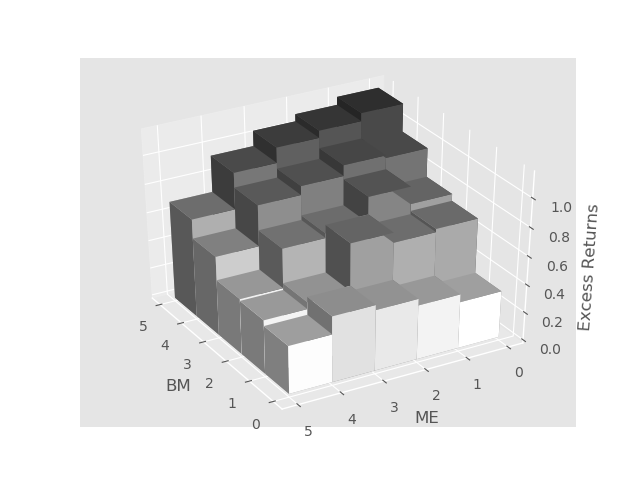

In [47]:
%matplotlib notebook
style.use('ggplot')

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

xx, yy = np.meshgrid(np.arange(5), np.arange(5))
BM, ME = xx.ravel(), yy.ravel()

dx = np.ones(len(BM))
dy = np.ones(len(ME))
dz = mean_exreturns[:-4].values

#Create Colormap
cmap = cm.get_cmap('binary') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 


ax1.bar3d(BM, ME, np.zeros(len(BM)), dx, dy, dz, color=rgba)

ax1.view_init(35,150)

ax1.set_xlabel('BM')
ax1.set_ylabel('ME')
ax1.set_zlabel('Excess Returns')

plt.show()

### Excersise 1.2

In [7]:
#Create a empty dictionary to store the results; (:-4) to exclude the FF Factors
results_dict = dict.fromkeys(list(excess_returns_ex1.columns[:-4]))

#Loop over all portfolios and regress:
#Excess_Return(Portfolio) = alpha + beta * Excess_Return(Market) + Std_Error
for portfolio_name in excess_returns_ex1.columns[:-4]:
    
    x = excess_returns_ex1['Mkt-RF']
    y = excess_returns_ex1[portfolio_name]
    
    beta, alpha, r_value, p_value, std_err = stats.linregress(x, y)
    
    results_dict[portfolio_name] = [alpha, beta, r_value, std_err**2]
    
results_ex1 = pd.DataFrame(results_dict, index = ['Alpha', 'Beta', 'R2', 'Std Error'])
results_ex1

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Alpha,-0.293545,0.170184,0.260052,0.494935,0.672094,-0.238948,0.155086,0.400355,0.528070,0.608278,...,-0.068812,-0.062854,0.218328,0.419833,0.472634,-0.097496,-0.046748,0.018162,0.189685,0.316787
Beta,1.423392,1.244513,1.149047,1.067264,1.100706,1.425819,1.228351,1.105138,1.032742,1.122175,...,1.225751,1.125530,1.036729,0.972244,1.081440,1.002311,0.978924,0.860066,0.847501,0.862343
R2,0.828762,0.828235,0.836235,0.818639,0.789311,0.889526,0.892000,0.885613,0.879849,0.849059,...,0.945000,0.950058,0.933757,0.902840,0.872881,0.932051,0.951849,0.900501,0.890095,0.804413
Std Error,0.002497,0.001916,0.001535,0.001515,0.001981,0.001450,0.001047,0.000908,0.000841,0.001318,...,0.000486,0.000369,0.000427,0.000579,0.000988,0.000410,0.000269,0.000466,0.000509,0.001096


In [8]:
#Sorts the values and list them in an output table

def create_output_table(coefficient, data):
    #coefficient has be a string
    
    #Create an empty dictionary to store the results in
    output = dict.fromkeys(['Low ME','ME2','ME3','ME4','High ME'])
    
    output['Low ME']  = data.loc[coefficient][0:5].values
    output['ME2']     = data.loc[coefficient][5:10].values
    output['ME3']     = data.loc[coefficient][10:15].values
    output['ME4']     = data.loc[coefficient][15:20].values
    output['High ME'] = data.loc[coefficient][20:25].values
    
    output_table = pd.DataFrame(output, index = ['Low BM', 'BM2', 'BM3', 'BM4', 'High BM']).T
    output_table.index.name = coefficient
    
    return output_table

In [9]:
#Create and print output table for Alpha
alpha = create_output_table('Alpha', results_ex1)
alpha

,Low BM,BM2,BM3,BM4,High BM
Alpha,,,,,
Low ME,-0.293545,0.170184,0.260052,0.494935,0.672094
ME2,-0.238948,0.155086,0.400355,0.528070,0.608278
ME3,-0.162261,0.256785,0.255127,0.479732,0.583655
ME4,-0.068812,-0.062854,0.218328,0.419833,0.472634
High ME,-0.097496,-0.046748,0.018162,0.189685,0.316787


In [10]:
#Create and print output table for Beta
beta = create_output_table('Beta', results_ex1)
beta

,Low BM,BM2,BM3,BM4,High BM
Beta,,,,,
Low ME,1.423392,1.244513,1.149047,1.067264,1.100706
ME2,1.425819,1.228351,1.105138,1.032742,1.122175
ME3,1.357361,1.156318,1.024763,0.975484,1.067429
ME4,1.225751,1.125530,1.036729,0.972244,1.081440
High ME,1.002311,0.978924,0.860066,0.847501,0.862343


In [11]:
#Create and print output table for Beta
R2 = create_output_table('R2', results_ex1)
R2

,Low BM,BM2,BM3,BM4,High BM
R2,,,,,
Low ME,0.828762,0.828235,0.836235,0.818639,0.789311
ME2,0.889526,0.892000,0.885613,0.879849,0.849059
ME3,0.921890,0.925255,0.909140,0.900540,0.855047
ME4,0.945000,0.950058,0.933757,0.902840,0.872881
High ME,0.932051,0.951849,0.900501,0.890095,0.804413


In [12]:
#Create and print output table for Beta
Std_Error = create_output_table('Std Error', results_ex1)
Std_Error

,Low BM,BM2,BM3,BM4,High BM
Std Error,,,,,
Low ME,0.002497,0.001916,0.001535,0.001515,0.001981
ME2,0.001450,0.001047,0.000908,0.000841,0.001318
ME3,0.000880,0.000607,0.000596,0.000599,0.001133
ME4,0.000486,0.000369,0.000427,0.000579,0.000988
High ME,0.000410,0.000269,0.000466,0.000509,0.001096


### Excercise 1.3

In [13]:
#Calculate Expected market return
exp_market_ret = np.mean(excess_returns_ex1['Mkt-RF'])

#Calculate expected portfolio return regarding to CAPM (Expected Market Return * Porfolio Beta)
plot_data = dict.fromkeys(excess_returns_ex1.columns[:-4])

for portfolio_name in excess_returns_ex1.columns[:-4]: 
    
    #Get Portfolio Beta
    port_beta = results_ex1.loc['Beta'][portfolio_name]
    
    #Store the prediction and the actual excess return in the dictionary plot_data
    plot_data[portfolio_name] = [port_beta * exp_market_ret, mean_exreturns[portfolio_name]]

plot_data = pd.DataFrame(plot_data, index = ['CAPM Prediction', 'Actual Excess Return'])

<IPython.core.display.Javascript object>


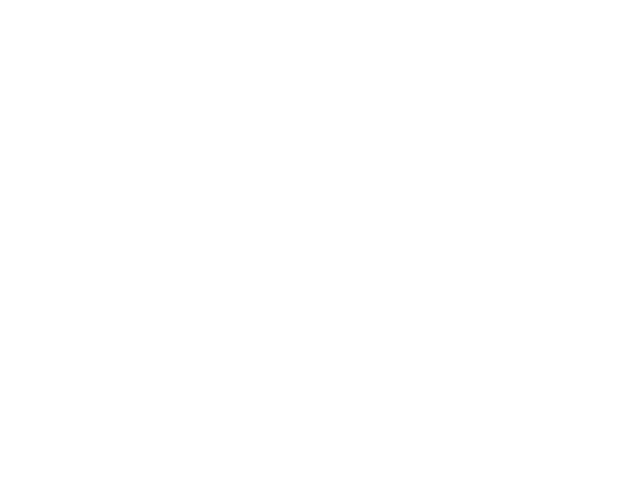

In [14]:
%matplotlib notebook
plt.scatter(plot_data.loc['CAPM Prediction'].values,plot_data.loc['Actual Excess Return'].values)
plt.plot(np.linspace(0,2), np.linspace(0,2), color = 'grey')

axes = plt.gca()
axes.set_xlim([0,1.2])
axes.set_ylim([0,1.2])
plt.gca().set_aspect('equal', adjustable = 'box')

chart_3 = plt.xlabel('Predicted Mean Excess Returns')
chart_3 = plt.ylabel('Mean Excess Returns')

plt.show()

### Excercise 2.1

In [15]:
#Create an empty dict to store the results in
results_ex2 = dict.fromkeys(excess_returns_ex1.columns[:-4])

#Define regression X values
X = np.array([excess_returns_ex1['Mkt-RF'].values] + 
                 [excess_returns_ex1['SMB'].values] + 
                 [excess_returns_ex1['HML'].values]).T 
X = sm.add_constant(X)

#________________________________________________________________________
#For Ex. 2.3 create values for predicting with the fitted model (add constant)
X_pred = np.array([np.mean([excess_returns_ex1['Mkt-RF'].values])] +
                  [np.mean([excess_returns_ex1['SMB'].values])] + 
                  [np.mean([excess_returns_ex1['HML'].values])])
X_pred = np.append(1.0,X_pred)

#________________________________________________________________________
#Regress each portfolio on X
for portfolio_name in excess_returns_ex1.columns[:-4]:
    
    Y = np.array(excess_returns_ex1[portfolio_name])

    model = sm.OLS(Y, X)
    results = model.fit()
    
    #Predict Excess Returns for Ex 2.3
    #In Sample
    exret_pred =  results.predict(X_pred)
    
    #Store Results in a dictionary
    results_ex2[portfolio_name] = [results.params[0],
                                   results.params[1],
                                   results.params[2],
                                   results.params[3], 
                                   results.bse[0], 
                                   results.rsquared, 
                                   exret_pred[0]]
   

In [16]:
#Convert the result dict into a dataframe
results_ex2 = pd.DataFrame(results_ex2, index = ['Alpha',
                                                 'Mkt-RF',
                                                 'SMB','HML', 
                                                 'Std Error Aplha', 
                                                 'R2', 'Pred. Ex. Ret (In Sample)'])
results_ex2

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Alpha,-0.379391,-0.114604,-0.089062,0.072007,0.086251,-0.141293,-0.018884,0.122848,0.130196,0.054446,...,0.137414,-0.131784,0.000880,0.063437,-0.003051,0.197878,-0.004568,-0.053771,-0.096162,-0.134584
Mkt-RF,1.039893,0.965751,0.933979,0.890530,0.954170,1.094342,1.017667,0.959494,0.968361,1.068542,...,1.064894,1.071969,1.043765,1.037819,1.144825,0.955553,1.021948,0.968589,1.002070,1.034809
SMB,1.410224,1.293279,1.153828,1.112233,1.205812,1.011670,0.927670,0.830921,0.699198,0.850663,...,0.299380,0.265627,0.238266,0.206378,0.357702,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294
HML,-0.284061,0.095127,0.248883,0.389023,0.641509,-0.478604,0.015927,0.224268,0.472373,0.695112,...,-0.447671,0.037550,0.302256,0.551833,0.711330,-0.449422,-0.012277,0.210888,0.549091,0.792266
Std Error Aplha,0.106342,0.077924,0.062337,0.061107,0.066358,0.080470,0.067520,0.063616,0.060720,0.065605,...,0.072621,0.079831,0.079281,0.078584,0.097666,0.066465,0.070061,0.087112,0.071896,0.112769
R2,0.933327,0.953228,0.964206,0.961792,0.960620,0.956168,0.958191,0.954802,0.953460,0.957150,...,0.945485,0.921030,0.911324,0.907387,0.891926,0.933567,0.919292,0.855326,0.900842,0.807556
Pred. Ex. Ret (In Sample),0.332709,0.717737,0.765602,0.964502,1.156374,0.388374,0.695528,0.886586,0.982448,1.102005,...,0.470486,0.432348,0.674461,0.847594,0.948439,0.343494,0.383952,0.396569,0.562563,0.696194


In [17]:
alpha2 = create_output_table('Alpha', results_ex2)
alpha2

,Low BM,BM2,BM3,BM4,High BM
Alpha,,,,,
Low ME,-0.379391,-0.114604,-0.089062,0.072007,0.086251
ME2,-0.141293,-0.018884,0.122848,0.130196,0.054446
ME3,-0.026888,0.119910,-0.017685,0.114475,0.063132
ME4,0.137414,-0.131784,0.000880,0.063437,-0.003051
High ME,0.197878,-0.004568,-0.053771,-0.096162,-0.134584


In [18]:
mktrf = create_output_table('Mkt-RF', results_ex2)
mktrf

,Low BM,BM2,BM3,BM4,High BM
Mkt-RF,,,,,
Low ME,1.039893,0.965751,0.933979,0.890530,0.954170
ME2,1.094342,1.017667,0.959494,0.968361,1.068542
ME3,1.101550,1.023491,0.963361,0.972274,1.062852
ME4,1.064894,1.071969,1.043765,1.037819,1.144825
High ME,0.955553,1.021948,0.968589,1.002070,1.034809


In [19]:
smb = create_output_table('SMB', results_ex2)
smb

,Low BM,BM2,BM3,BM4,High BM
SMB,,,,,
Low ME,1.410224,1.293279,1.153828,1.112233,1.205812
ME2,1.011670,0.927670,0.830921,0.699198,0.850663
ME3,0.708367,0.617650,0.538221,0.451434,0.643342
ME4,0.299380,0.265627,0.238266,0.206378,0.357702
High ME,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294


In [20]:
hml = create_output_table('HML', results_ex2)
hml

,Low BM,BM2,BM3,BM4,High BM
HML,,,,,
Low ME,-0.284061,0.095127,0.248883,0.389023,0.641509
ME2,-0.478604,0.015927,0.224268,0.472373,0.695112
ME3,-0.450741,0.046924,0.305873,0.492020,0.701168
ME4,-0.447671,0.037550,0.302256,0.551833,0.711330
High ME,-0.449422,-0.012277,0.210888,0.549091,0.792266


In [21]:
std_alpha = create_output_table('Std Error Aplha', results_ex2)
std_alpha

,Low BM,BM2,BM3,BM4,High BM
Std Error Aplha,,,,,
Low ME,0.106342,0.077924,0.062337,0.061107,0.066358
ME2,0.080470,0.067520,0.063616,0.060720,0.065605
ME3,0.072989,0.070753,0.070312,0.064927,0.082198
ME4,0.072621,0.079831,0.079281,0.078584,0.097666
High ME,0.066465,0.070061,0.087112,0.071896,0.112769


In [22]:
r2 = create_output_table('R2', results_ex2)
r2

,Low BM,BM2,BM3,BM4,High BM
R2,,,,,
Low ME,0.933327,0.953228,0.964206,0.961792,0.960620
ME2,0.956168,0.958191,0.954802,0.953460,0.957150
ME3,0.957262,0.944257,0.932328,0.937519,0.924603
ME4,0.945485,0.921030,0.911324,0.907387,0.891926
High ME,0.933567,0.919292,0.855326,0.900842,0.807556


### Excercise 2.2

<IPython.core.display.Javascript object>


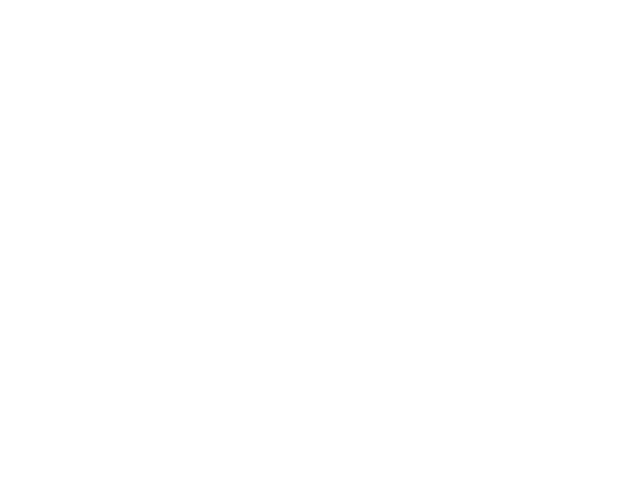

In [23]:
%matplotlib notebook
style.use('ggplot')

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

xx, yy = np.meshgrid(np.arange(5), np.arange(5))
BM, ME = xx.ravel(), yy.ravel()

dx = np.ones(len(BM))
dy = np.ones(len(ME))
dz = results_ex2.loc['Alpha'].values

#Create Colormap
cmap = cm.get_cmap('Reds') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 


ax1.bar3d(BM, ME, np.zeros(len(BM)), dx, dy, dz, color = rgba)

ax1.view_init(40,40)

ax1.set_xlabel('BM')
ax1.set_ylabel('ME')
ax1.set_zlabel('Excess Returns')

plt.show()

### Excercise 2.3

<IPython.core.display.Javascript object>


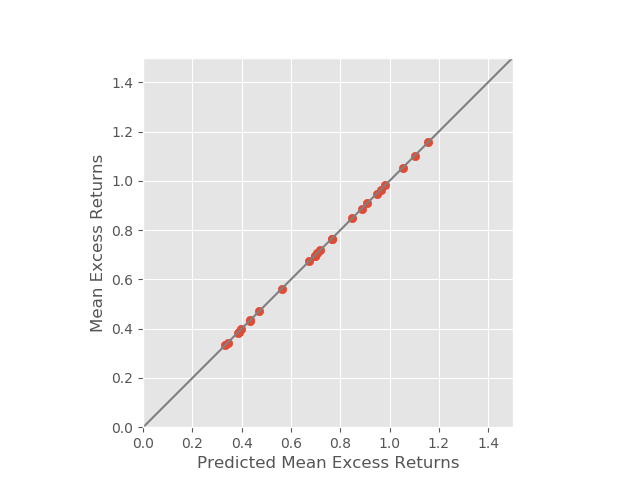

In [24]:
%matplotlib notebook
plt.scatter(results_ex2.loc['Pred. Ex. Ret (In Sample)'].values,mean_exreturns[:-4].values)
plt.plot(np.linspace(0,2), np.linspace(0,2), color = 'grey')

axes = plt.gca()
axes.set_xlim([0,1.5])
axes.set_ylim([0,1.5])
plt.gca().set_aspect('equal', adjustable = 'box')

chart_3 = plt.xlabel('Predicted Mean Excess Returns')
chart_3 = plt.ylabel('Mean Excess Returns')

plt.show()

### Excercise 2.4

In [25]:
#See Answer Sheet

### Excercise 2.5

In [26]:
#For Ex. 2.5 prepare out of sample data
excess_returns_ex25 = ex_returns_complete.loc['1994-01-01':'2017-12-01']

#Create an empty dict to store the results in
results_ex25 = dict.fromkeys(excess_returns_ex25.columns[:-4])

In [27]:
#Define regression X values
X = np.array([excess_returns_ex25['Mkt-RF'].values] + 
                 [excess_returns_ex25['SMB'].values] + 
                 [excess_returns_ex25['HML'].values]).T 
X = sm.add_constant(X)

for portfolio_name in excess_returns_ex25.columns[:-4]:
    
    Y = np.array(excess_returns_ex25[portfolio_name])

    model = sm.OLS(Y, X)
    results = model.fit()
    
    #Predict Excess Returns for Ex 2.3
    #In Sample
    exret_pred =  results.predict(X_pred)
    
    #Store Results in a dictionary
    results_ex25[portfolio_name] = [results.params[0],
                                   results.params[1],
                                   results.params[2],
                                   results.params[3], 
                                   results.bse[0], 
                                   results.rsquared, 
                                   exret_pred[0]]

In [28]:
#Convert the result dict into a dataframe
results_ex25 = pd.DataFrame(results_ex2, index = ['Alpha',
                                                 'Mkt-RF',
                                                 'SMB','HML', 
                                                 'Std Error Aplha', 
                                                 'R2', 'Pred. Ex. Ret (In Sample)', 
                                                 'Pred. Ex. Ret (Out of Sample)'])
results_ex25

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Alpha,-0.379391,-0.114604,-0.089062,0.072007,0.086251,-0.141293,-0.018884,0.122848,0.130196,0.054446,...,0.137414,-0.131784,0.000880,0.063437,-0.003051,0.197878,-0.004568,-0.053771,-0.096162,-0.134584
Mkt-RF,1.039893,0.965751,0.933979,0.890530,0.954170,1.094342,1.017667,0.959494,0.968361,1.068542,...,1.064894,1.071969,1.043765,1.037819,1.144825,0.955553,1.021948,0.968589,1.002070,1.034809
SMB,1.410224,1.293279,1.153828,1.112233,1.205812,1.011670,0.927670,0.830921,0.699198,0.850663,...,0.299380,0.265627,0.238266,0.206378,0.357702,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294
HML,-0.284061,0.095127,0.248883,0.389023,0.641509,-0.478604,0.015927,0.224268,0.472373,0.695112,...,-0.447671,0.037550,0.302256,0.551833,0.711330,-0.449422,-0.012277,0.210888,0.549091,0.792266
Std Error Aplha,0.106342,0.077924,0.062337,0.061107,0.066358,0.080470,0.067520,0.063616,0.060720,0.065605,...,0.072621,0.079831,0.079281,0.078584,0.097666,0.066465,0.070061,0.087112,0.071896,0.112769
R2,0.933327,0.953228,0.964206,0.961792,0.960620,0.956168,0.958191,0.954802,0.953460,0.957150,...,0.945485,0.921030,0.911324,0.907387,0.891926,0.933567,0.919292,0.855326,0.900842,0.807556
Pred. Ex. Ret (In Sample),0.332709,0.717737,0.765602,0.964502,1.156374,0.388374,0.695528,0.886586,0.982448,1.102005,...,0.470486,0.432348,0.674461,0.847594,0.948439,0.343494,0.383952,0.396569,0.562563,0.696194
Pred. Ex. Ret (Out of Sample),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
alpha25 = create_output_table('Alpha', results_ex25)
alpha25

,Low BM,BM2,BM3,BM4,High BM
Alpha,,,,,
Low ME,-0.379391,-0.114604,-0.089062,0.072007,0.086251
ME2,-0.141293,-0.018884,0.122848,0.130196,0.054446
ME3,-0.026888,0.119910,-0.017685,0.114475,0.063132
ME4,0.137414,-0.131784,0.000880,0.063437,-0.003051
High ME,0.197878,-0.004568,-0.053771,-0.096162,-0.134584


In [30]:
mktrf25 = create_output_table('Mkt-RF', results_ex25)
mktrf25

,Low BM,BM2,BM3,BM4,High BM
Mkt-RF,,,,,
Low ME,1.039893,0.965751,0.933979,0.890530,0.954170
ME2,1.094342,1.017667,0.959494,0.968361,1.068542
ME3,1.101550,1.023491,0.963361,0.972274,1.062852
ME4,1.064894,1.071969,1.043765,1.037819,1.144825
High ME,0.955553,1.021948,0.968589,1.002070,1.034809


In [31]:
smb25 = create_output_table('SMB', results_ex25)
smb25

,Low BM,BM2,BM3,BM4,High BM
SMB,,,,,
Low ME,1.410224,1.293279,1.153828,1.112233,1.205812
ME2,1.011670,0.927670,0.830921,0.699198,0.850663
ME3,0.708367,0.617650,0.538221,0.451434,0.643342
ME4,0.299380,0.265627,0.238266,0.206378,0.357702
High ME,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294


In [32]:
hml25 = create_output_table('HML', results_ex25)
hml25

,Low BM,BM2,BM3,BM4,High BM
HML,,,,,
Low ME,-0.284061,0.095127,0.248883,0.389023,0.641509
ME2,-0.478604,0.015927,0.224268,0.472373,0.695112
ME3,-0.450741,0.046924,0.305873,0.492020,0.701168
ME4,-0.447671,0.037550,0.302256,0.551833,0.711330
High ME,-0.449422,-0.012277,0.210888,0.549091,0.792266


In [33]:
std_alpha25 = create_output_table('Std Error Aplha', results_ex25)
std_alpha25

,Low BM,BM2,BM3,BM4,High BM
Std Error Aplha,,,,,
Low ME,0.106342,0.077924,0.062337,0.061107,0.066358
ME2,0.080470,0.067520,0.063616,0.060720,0.065605
ME3,0.072989,0.070753,0.070312,0.064927,0.082198
ME4,0.072621,0.079831,0.079281,0.078584,0.097666
High ME,0.066465,0.070061,0.087112,0.071896,0.112769


In [34]:
r2_25 = create_output_table('R2', results_ex25)
r2_25

,Low BM,BM2,BM3,BM4,High BM
R2,,,,,
Low ME,0.933327,0.953228,0.964206,0.961792,0.960620
ME2,0.956168,0.958191,0.954802,0.953460,0.957150
ME3,0.957262,0.944257,0.932328,0.937519,0.924603
ME4,0.945485,0.921030,0.911324,0.907387,0.891926
High ME,0.933567,0.919292,0.855326,0.900842,0.807556


### Excercise 3

### Import Data

In [35]:
#Import Portfolio Data (100 portfolios)
data100 = pd.read_csv('100_Portfolios_10x10.CSV', skiprows = list(range(0,15)), dtype = np.float64, nrows = 1107)

#Convert Date of Data100
data100['Date'] = pd.to_datetime(data100['Unnamed: 0'], format = '%Y%m.0')

#Set Index to Date and delete old Date column of Data100
data100 = data100.set_index('Date')
data100 = data100.drop('Unnamed: 0', axis = 1)

#Import FF Factors
FF_Factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = [0,1,2], dtype = np.float64, nrows = 1107)

#Convert Date of FF_Factors
FF_Factors['Date'] = pd.to_datetime(FF_Factors['Unnamed: 0'], format = '%Y%m.0')

#Set Index to Date and delete old Date column of FF_Factors
FF_Factors = FF_Factors.set_index('Date')
FF_Factors = FF_Factors.drop('Unnamed: 0', axis = 1)

#Only use data from July 1926 to December 2017 and replace missing values
data100 = data100.loc['1926-07-01':'2017-12-01']
data100 = data100.replace(-99.99,np.nan)

#Add the FF Factors to data100
data100 = pd.concat([data100, FF_Factors], axis = 1, join = 'inner')

#Calculate Excess Returns
data100_exreturns = pd.DataFrame()

for i in data100.columns[:-4]:
    data100_exreturns[i] = data100[i] - data100['RF']

#Add FF Factors, RF 
data100_exreturns = pd.concat([data100_exreturns, FF_Factors], axis = 1, join = 'inner')

#Rename data100_exreturns to dataset for easier use
dataset = data100_exreturns

#From now on, only use dataset. No other dataframes anymore!
dataset.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-01,NaN,12.1456,NaN,-20.8549,-6.7064,-4.9629,-5.1012,15.5076,-1.8598,-2.6670,...,1.7259,2.2634,2.9444,0.1178,0.6376,NaN,2.96,-2.30,-2.87,0.22
1926-08-01,NaN,2.7404,NaN,7.7500,6.4995,-3.8139,-4.3688,-1.9029,-5.6324,9.3515,...,0.8927,2.7763,5.8436,5.8106,10.9745,NaN,2.64,-1.40,4.19,0.25
1926-09-01,NaN,-18.8130,NaN,-3.9337,-5.2812,-2.4039,-4.8014,-10.8400,0.2619,7.5148,...,-1.1485,0.8589,-0.7736,-1.1824,-1.3003,NaN,0.36,-1.32,0.01,0.23
1926-10-01,NaN,-4.4569,NaN,-11.8585,-5.7196,-18.0978,3.2354,-9.5433,-9.4793,-2.0661,...,-1.8945,-2.2402,-5.6735,-1.2815,-4.2446,NaN,-3.24,0.04,0.51,0.32
1926-11-01,NaN,-8.5689,NaN,34.4726,0.9196,-0.1073,-5.1889,-3.5110,-2.1559,-2.8521,...,0.8347,0.5711,3.3476,3.4117,2.9580,NaN,2.53,-0.20,-0.35,0.31


In [56]:
#Create a time window that contains the portfolio returns as well as the risk factors
def create_time_window(portfolio_name, start_date):
    
    time_window = pd.DataFrame()
    time_window[portfolio_name] = dataset[portfolio_name]

    time_window['Mkt-RF'] = dataset['Mkt-RF']
    #time_window['SMB'] = dataset['SMB']
    #time_window['HML'] = dataset['HML']
    
    time_window = time_window.loc[start_date.strftime('%Y-%m-%d'):(start_date + relativedelta(months = 60)).strftime('%Y-%m-%d')].dropna()
    
    if len(time_window) > 10:
        return time_window
    
    else: 
        return "NaN"
        

In [57]:
#Calculate the betas with on the rolling time window defined above
def calculate_rolling_betas(start_dates, portfolios):
    
    output_beta = pd.DataFrame(index = dataset.index, columns = list(portfolios))
    
    for date in start_dates:
        
        for portfolio_name in portfolios:

            time_window = create_time_window(portfolio_name, pd.to_datetime(date))

            if type(time_window) != str:

                X = np.array([time_window['Mkt-RF'].values]).T 
                X = sm.add_constant(X)

                Y = np.array(time_window[portfolio_name])

                model = sm.OLS(Y, X)
                results = model.fit()

                aplha = results.params[0]
                beta = results.params[1]

                output_beta[portfolio_name][date] = beta

    return output_beta

### Excercise 3.1

In [58]:
start_dates31 = ['1931-08-01', '1931-09-01', '1931-10-01', '2016-12-01', '2017-12-01']

portfolios31 = dataset.columns[[1,9,15,49,99]]

output31 = calculate_rolling_betas(start_dates31, portfolios31)

In [59]:
output31.loc['1931-08-01']

ME1 BM2       2.05935
SMALL HiBM     1.9102
ME2 BM6       1.70251
ME5 BM10      2.13211
BIG HiBM          NaN
Name: 1931-08-01 00:00:00, dtype: object

In [60]:
output31.loc['1931-09-01']

ME1 BM2       2.05935
SMALL HiBM    1.90896
ME2 BM6       1.70199
ME5 BM10      2.13139
BIG HiBM          NaN
Name: 1931-09-01 00:00:00, dtype: object

In [61]:
output31.loc['1931-10-01']

ME1 BM2       2.05935
SMALL HiBM    2.00943
ME2 BM6       1.77167
ME5 BM10      2.23327
BIG HiBM          NaN
Name: 1931-10-01 00:00:00, dtype: object

In [62]:
output31.loc['2016-12-01']

ME1 BM2        1.10422
SMALL HiBM    0.625021
ME2 BM6        1.54656
ME5 BM10       1.60341
BIG HiBM       2.11384
Name: 2016-12-01 00:00:00, dtype: object

In [63]:
output31.loc['2017-12-01']

ME1 BM2       NaN
SMALL HiBM    NaN
ME2 BM6       NaN
ME5 BM10      NaN
BIG HiBM      NaN
Name: 2017-12-01 00:00:00, dtype: object

### Excercise 3.2

In [53]:
#Get a list of all start dates
all_start_dates = []

for i in range(0,len(list(dataset.index))):
    
    all_start_dates.append(list(dataset.index)[i].strftime("%Y-%m-%d"))
    
# Get a list of all portfolios
all_portfolios = dataset.columns[:-4]

In [54]:
#Calculate the betas for all portfolios at start dates
output32 = calculate_rolling_betas(all_start_dates, all_portfolios)

In [55]:
#Write the results in a excel sheet
writer = pd.ExcelWriter('BetasEx3.xlsx')
output32.to_excel(writer,'Sheet1')
writer.save()